# Proyecto 1 - Red Neuronal para Detección de BBoxes y Clase
- **Integrantes:**
    - Haces López, José Manuel - 734759 - Ing. Y Ciencia de Datos
    - Quintero Pérez, Marcela - 717644 - Ing. Y Ciencia de Datos
___
El reto que se propone en este proyecto consiste en construir un modelo para el problema de clasificación y localización de objetos en imágenes. Para entrenar, validar y probar el modelo, utilizaremos el conjunto de datos Tiny Imagenet que tiene 200 clases. Cada clase tiene 500 imágenes de entrenamiento, 50 imágenes de validación y 50 imágenes de prueba.

El alcance esperado para el primer avance es:
- Datos reorganizados (en caso de ser necesario)
- Pipeline de datos de entrenamiento, validación y pruebas
    - Generadores de datos
    - Aumento de datos (en caso de ser necesario)

In [1]:
# Librerías
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Archivo .py con funciones
import Utilidades

## 1. Carga de Datos

In [2]:
# Tabla wnids (IDS de las clases que tenemos)
wnids = pd.read_fwf('./Data/wnids.txt', header=None)
wnids.columns = ['Clase'] # Cambiando el nombre a la columna

print(f'Contamos con {wnids["Clase"].nunique()} clases distintas.')
wnids.head()

Contamos con 200 clases distintas.


,Clase
0,n02124075
1,n04067472
2,n04540053
3,n04099969
4,n07749582


In [3]:
# Tabla words (Nombres de las clases)
words = pd.read_fwf('./Data/words.txt', header=None)
words.columns = ['Clase', 'Tipo_Clase', 'NaN']
words = words[['Clase', 'Tipo_Clase']]

# Contando cuántos 'TiposClase' hay por 'Clase'
words = words.groupby('Clase')['Tipo_Clase'].unique().reset_index(drop=False)

# Imprimiendo número de clases que hay en el archivo y el ínicio del dataset
print(f'Contamos con {words["Clase"].nunique()} clases distintas.')
words.head()

Contamos con 82115 clases distintas.


,Clase,Tipo_Clase
0,n00001740,[entity]
1,n00001930,[physical entity]
2,n00002137,"[abstraction, abstract entity]"
3,n00002452,[thing]
4,n00002684,"[object, physical object]"


- Al tener dos archivos distintos, uno con las clases que tenemos "wnids.txt" y otra con las 82115 clases que existen, mergeamos las dos para obtener el 'inner' de los dos conjuntos y obtener una tabla con las clases y la etiqueta.

In [4]:
# Mergeando las tablas por obtener el 'inner' de los dos
clases = words.merge(wnids, on='Clase')

# Creando un DF con las clases y su ID
clases_num = clases[['Clase']].reset_index().rename(columns={'index': 'Num_Clase'})
# Diccionario con los Nombres y el ID
dict_clases = {}
for i in clases_num['Clase']:
    temp = clases_num[clases_num['Clase'] == i].reset_index(drop=True)
    dict_clases[i] = temp['Num_Clase'][0]
# Exportando Dict
with open("./Varios/Dict_Clases.pkl", "wb") as path_dic:
    pickle.dump(dict_clases, path_dic)

clases

,Clase,Tipo_Clase
0,n01443537,"[goldfish, Carassius auratus]"
1,n01629819,"[European fire salamander, Salamandra salamandr]"
2,n01641577,"[bullfrog, Rana catesbeiana]"
3,n01644900,"[tailed frog, bell toad, ribbed toad, tailed to]"
4,n01698640,"[American alligator, Alligator mississipiensis]"
...,...,...
195,n09246464,"[cliff, drop, drop-off]"
196,n09256479,[coral reef]
197,n09332890,"[lakeside, lakeshore]"
198,n09428293,"[seashore, coast, seacoast, sea-coast]"


## 2. EDA sobre las carpetas de 'Data'

In [5]:
# Path de los datos
path = './Data/'

# Utilizando la función para ver el contenido de los folders
Utilidades.folders_content(path)

- Contenido de la carpeta Test:
	- images/

- Contenido de la carpeta Train:
	- n01443537/
	- n01629819/
	- n01641577/
	- n01644900/
	- n01698640/
	- Más 195 carpetas.

- Contenido de la carpeta Val:
	- images/
	- val_annotations.txt

- Contenido de la carpeta Validation:
	- n01443537/
	- n01629819/
	- n01641577/
	- n01644900/
	- n01698640/
	- Más 195 carpetas.



**Conclusiones:**

- Después de un anális se llegó a la concusión de que la jerarquía de las carpetas es:
    - Test/
        - images/
            - Imagenes de Test
    - Train/
        - Carpeta con las imágenes de esa etiqueta/
            - images/
            - etiqueta_boxes.txt
    - Val/
        - images/
        - val_annotation.txt

## 3. Manejo de Carpetas
Necesitamos hacer un cambio en el orden de la carpeta de Validación (Val), ya que tiene un formato diferente que al de Entrenamiento (Train)

In [6]:
# Anotaciones del dataset de Validation
val_annotations = pd.read_csv('./Data/Val/val_annotations.txt', sep='\t', header=None)
val_annotations.columns = ['Img_Name', 'Clase', 'Xmin', 'Ymin', 'Xmax', 'Ymax'] # Cambiando columnas
val_annotations

,Img_Name,Clase,Xmin,Ymin,Xmax,Ymax
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48
...,...,...,...,...,...,...
9995,val_9995.JPEG,n03085013,0,0,63,63
9996,val_9996.JPEG,n03444034,0,9,63,63
9997,val_9997.JPEG,n03424325,10,10,38,42
9998,val_9998.JPEG,n01629819,28,18,63,31


## 4) Generadores de Datos

In [7]:
# Haciendo los Generadores de Datos
data_train = Utilidades.data_generator(path='./Data/Train/')
val_train = Utilidades.data_generator(path='./Data/Validation/')

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


## 5) Modelado
### 5.1) Arquitectura

In [8]:
# Creando la arquitectura de la red
# Modelo Pre-entrenado
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
vgg.trainable = False
output_vgg = vgg.output
x = Flatten(name='Flatten')(output_vgg)
# ----------------------------------------------------------------------------------------------
# Capas ocultas BBox
x1 = Dense(512, activation = "relu", name='Oculta1_BBox')(x)
x1 = Dropout(0.3)(x1)
x1 = Dense(512, activation = "relu", name='Oculta2_BBox')(x1)
x1 = Dense(256, activation= "relu", name='Oculta3_BBox')(x1)
# Capas de salida
output_tensor_bbox = Dense(4, name='Output_Bbox')(x1)
# ----------------------------------------------------------------------------------------------
# Capas ocultas BBox
x2 = Dense(256, activation = "relu", name='Oculta1_Class')(x)
x2 = Dropout(0.3)(x2)
x2 = Dense(256, activation = "relu", name='Oculta2_Class')(x2)
x2 = Dense(64, activation= "relu", name='Oculta3_Class')(x2)
output_tensor_class = Dense(1, activation='softmax', name='Output_Class')(x2)

# ----------------------------------------------------------------------------------------------
# Creando el modelo
model = Model(inputs= (vgg.input) , outputs=[output_tensor_bbox, output_tensor_class])

# ----------------------------------------------------------------------------------------------
# Sacando el resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 32, 32, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

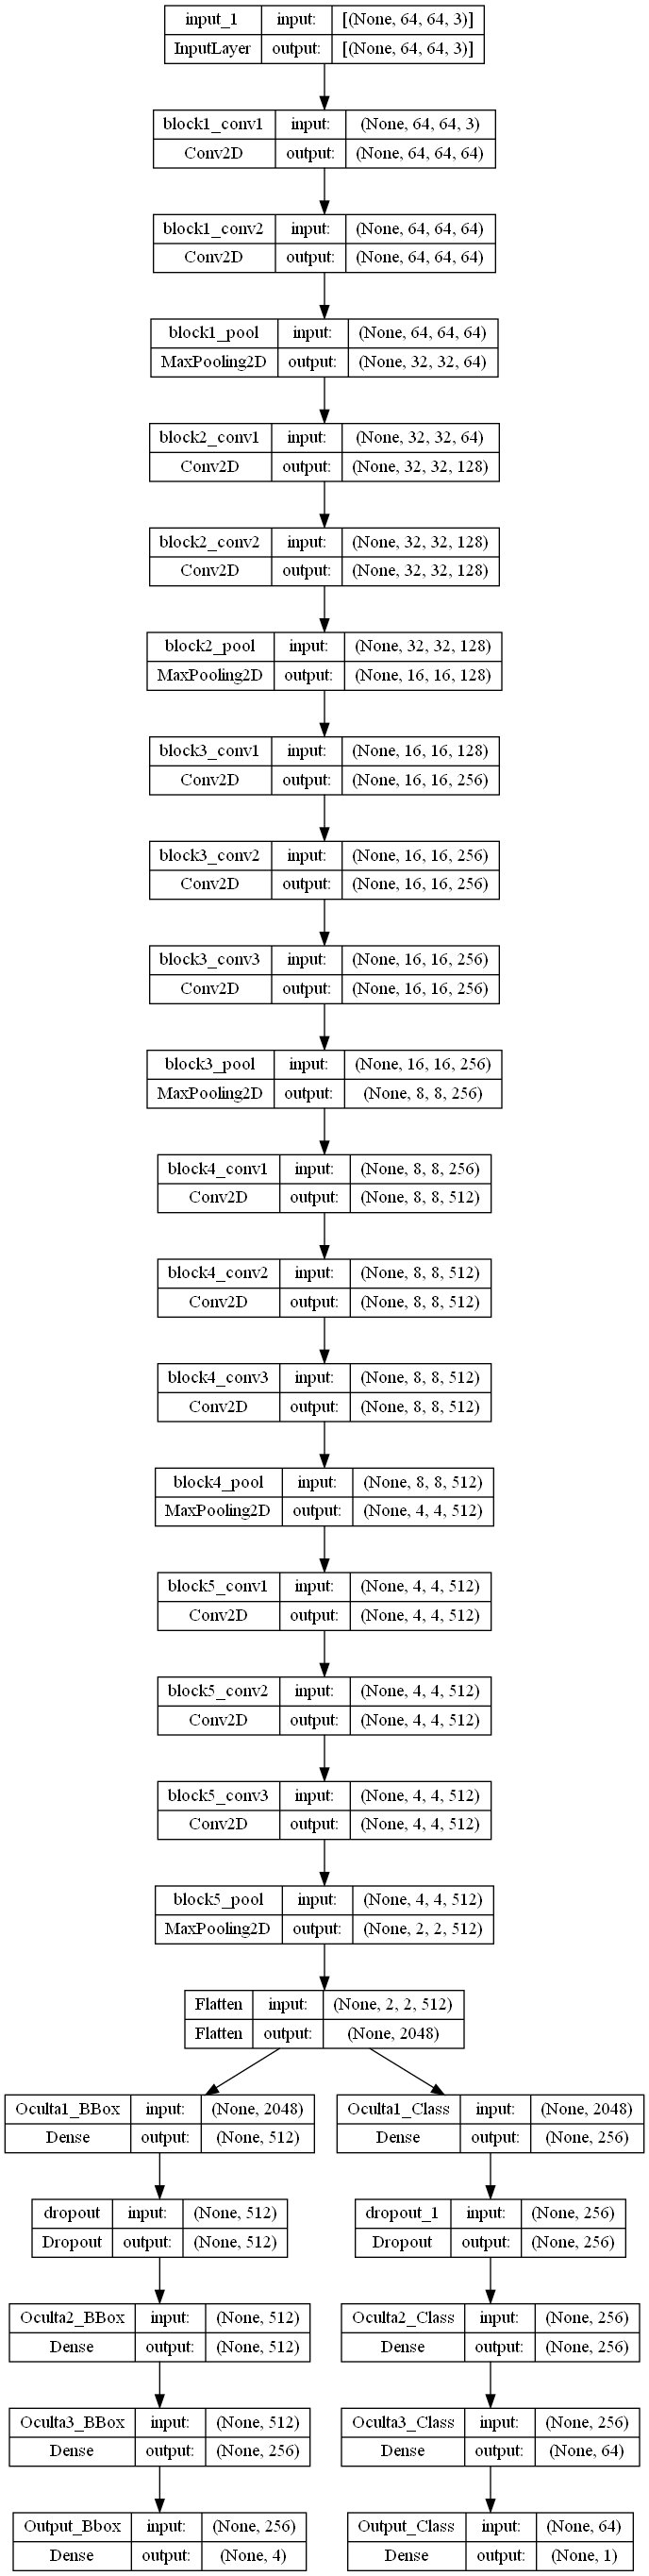

In [9]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 5.2) Compilación

In [10]:
model.compile(optimizer=Adam(learning_rate=0.003),
              loss={'Output_Bbox': 'mse', 
                    'Output_Class': 'sparse_categorical_crossentropy'},
              metrics={'Output_Bbox': Utilidades.iou_metric, 
                       'Output_Class': 'accuracy'})

In [12]:
model.fit(data_train, 
          validation_data=val_train,
          epochs=100,
          verbose=1,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
                     tf.keras.callbacks.ModelCheckpoint(filepath='./Checkpoints/model.h5', save_best_only=True, save_weights_only=False)])